<a href="https://colab.research.google.com/github/dssg/ai4med/blob/main/explore_emr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring EMR Data

## Getting Set up

Running the code below will create a local postgres 13 database for you and
import the sample data. Don't worry about the details of that and you shouldn't need to touch any of the code here aside from running it. Below, we'll talk about how to access the database from within the notebook to run queries.

In [1]:
# Install and start postgresql-13 server
!sudo apt-get -y -qq update
!wget --quiet -O - https://www.postgresql.org/media/keys/ACCC4CF8.asc | sudo apt-key add -
!echo "deb http://apt.postgresql.org/pub/repos/apt/ `lsb_release -cs`-pgdg main" |sudo tee  /etc/apt/sources.list.d/pgdg.list
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql-13 postgresql-client-13
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"
!sudo -u postgres psql -U postgres -c "CREATE USER dssg_admin PASSWORD 'dssg_admin';"
!sudo -u postgres psql -U postgres -c "ALTER USER dssg_admin WITH SUPERUSER;"
!sudo -u postgres psql -U postgres -c "DROP DATABASE IF EXISTS mimic;"
!sudo -u postgres psql -U postgres -c "create database mimic owner dssg_admin;"

# Setup a database with name `mimic` to be used

# Environment variables for connecting to the database
%env DEMO_DATABASE_NAME=mimic
%env DEMO_DATABASE_HOST=localhost
%env DEMO_DATABASE_PORT=5432
%env DEMO_DATABASE_USER=dssg_admin
%env DEMO_DATABASE_PASS=dssg_admin

OK
deb http://apt.postgresql.org/pub/repos/apt/ jammy-pgdg main
W: http://apt.postgresql.org/pub/repos/apt/dists/jammy-pgdg/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 12.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libjson-perl.
(Reading database ... 121925 files and directories currently installed.)
Preparing to unpack .../00-libjson-perl_4.04000-1_all.deb ...
Unpacking libjson-perl (4.04000-1) ...
Selecting previously unselected package netbase.
Preparing to un

## Download sample data and load it into our postgresql database server
You might see some warnings or errors but ignore them for now

In [2]:
# Download sample data and load it into our postgres server
!curl -s -OL https://dsapp-public-data-migrated.s3.us-west-2.amazonaws.com/mimicsample.dump
!PGPASSWORD=$DEMO_DATABASE_PASS pg_restore -h $DEMO_DATABASE_HOST -p $DEMO_DATABASE_PORT -d $DEMO_DATABASE_NAME -U $DEMO_DATABASE_USER -O -j 8 mimicsample.dump

pg_restore: while PROCESSING TOC:
pg_restore: from TOC entry 4270; 0 0 ACL SCHEMA public rg_staff
pg_restore: error: could not execute query: ERROR:  role "rdsadmin" does not exist
Command was: REVOKE ALL ON SCHEMA public FROM rdsadmin;
REVOKE ALL ON SCHEMA public FROM PUBLIC;
GRANT ALL ON SCHEMA public TO rg_staff;
GRANT ALL ON SCHEMA public TO PUBLIC;


pg_restore: warning: errors ignored on restore: 2


In [4]:
# Install triage and its dependencies
!pip install triage


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.6/257.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 12.1 MB/s eta 0:00:00
  Using cached SQLAlchemy-1.3.18-cp310-cp310-linux_x86_64.whl
  Using cached PyYAML-6.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (682 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 52.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 5.2 MB/s eta

# **You might need to run the cell below twice if you get an error the first time**

---



In [2]:
from sqlalchemy.engine.url import URL
from sqlalchemy import create_engine
import pandas as pd
pd.set_option('display.max_columns', None)

db_url = URL(
            'postgres',
            host='localhost',
            username='dssg_admin',
            database='mimic',
            password='dssg_admin',
            port=5432,
        )

db_engine = create_engine(db_url)


## Let's look at the patients table

In [6]:
pd.read_sql('SELECT * FROM mimiciii.patients', db_engine)

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,1.0,2.0,M,2138-07-17,NaT,NaT,NaT,0.0
1,2.0,3.0,M,2025-04-11,2102-06-14,NaT,2102-06-14,1.0
2,3.0,4.0,F,2143-05-12,NaT,NaT,NaT,0.0
3,4.0,5.0,M,2103-02-02,NaT,NaT,NaT,0.0
4,5.0,6.0,F,2109-06-21,NaT,NaT,NaT,0.0
...,...,...,...,...,...,...,...,...
9995,9996.0,10562.0,M,2157-06-02,NaT,NaT,NaT,0.0
9996,9997.0,10563.0,M,2047-04-16,2110-04-08,NaT,2110-04-08,1.0
9997,9998.0,10564.0,M,2072-04-19,2138-03-04,NaT,2138-03-04,1.0
9998,9999.0,10565.0,F,2060-12-01,2118-09-24,NaT,2118-09-24,1.0


## Now we can do the same for other tables in the data
 - admissions
 - icustays
 - ...


## We can load a table into a dataframe in python

In [8]:
patients = pd.read_sql('SELECT * FROM mimiciii.patients', db_engine)
patients.head()

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,1.0,2.0,M,2138-07-17,NaT,NaT,NaT,0.0
1,2.0,3.0,M,2025-04-11,2102-06-14,NaT,2102-06-14,1.0
2,3.0,4.0,F,2143-05-12,NaT,NaT,NaT,0.0
3,4.0,5.0,M,2103-02-02,NaT,NaT,NaT,0.0
4,5.0,6.0,F,2109-06-21,NaT,NaT,NaT,0.0


In [9]:
# prompt: code to join database tables

import pandas as pd
# Join patients and admissions tables on the subject_id column
joined_table = pd.read_sql('''
SELECT *
FROM mimiciii.patients AS p
INNER JOIN mimiciii.admissions AS a
ON p.subject_id = a.subject_id
''', db_engine)

# Print the first few rows of the joined table
joined_table.head()


,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,1.0,2.0,M,2138-07-17,NaT,NaT,NaT,0.0,1.0,2.0,163353.0,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,None,NOT SPECIFIED,None,ASIAN,NaT,NaT,NEWBORN,0.0,1.0
1,2.0,3.0,M,2025-04-11,2102-06-14,NaT,2102-06-14,1.0,2.0,3.0,145834.0,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,None,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0.0,1.0
2,3.0,4.0,F,2143-05-12,NaT,NaT,NaT,0.0,3.0,4.0,185777.0,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0.0,1.0
3,4.0,5.0,M,2103-02-02,NaT,NaT,NaT,0.0,4.0,5.0,178980.0,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,None,BUDDHIST,None,ASIAN,NaT,NaT,NEWBORN,0.0,1.0
4,5.0,6.0,F,2109-06-21,NaT,NaT,NaT,0.0,5.0,6.0,107064.0,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaT,NaT,CHRONIC RENAL FAILURE/SDA,0.0,1.0


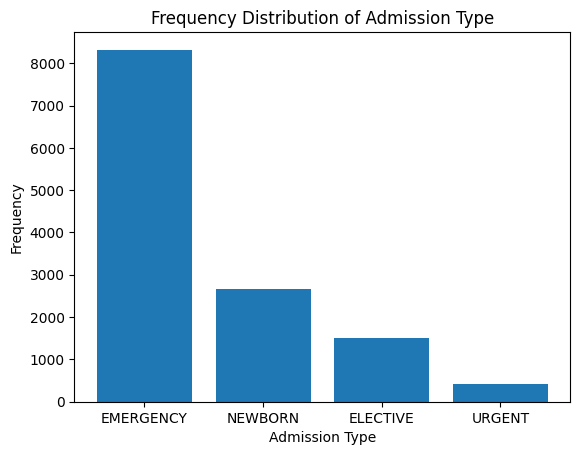

In [10]:
# prompt: plot frequency distribution of admission_type

import matplotlib.pyplot as plt

# Create a bar chart of admission type frequencies
plt.bar(joined_table['admission_type'].value_counts().index, joined_table['admission_type'].value_counts().values)
plt.xlabel('Admission Type')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Admission Type')
plt.show()


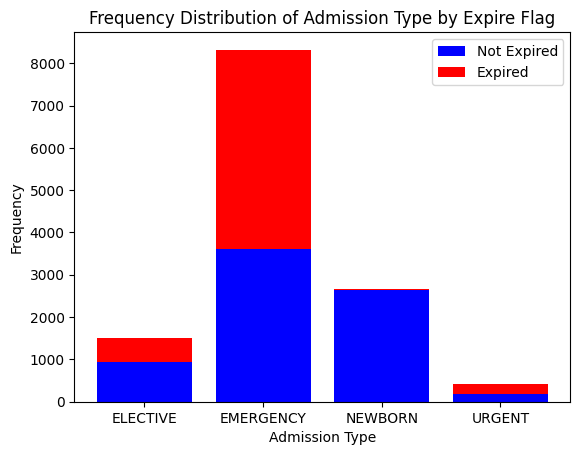

In [12]:
# prompt: color by expire_flag

import matplotlib.pyplot as plt

# Group the data by admission type and expire_flag
grouped_data = joined_table.groupby(['admission_type', 'expire_flag']).size().unstack()

# Create a bar chart with different colors for each expire_flag
plt.bar(grouped_data.index, grouped_data[0], label='Not Expired', color='blue')
plt.bar(grouped_data.index, grouped_data[1], bottom=grouped_data[0], label='Expired', color='red')

plt.xlabel('Admission Type')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Admission Type by Expire Flag')
plt.legend()
plt.show()


Homework Assignment

**Question 1: Diagnoses**

1A. What are the 10 most common diagnoses (names of the diagnosis - not just the code) in this sample data?
Hint: you'll need to look at the **icd_diagnoses** table to get diagnosis codes and the **d_icd_diagnoses** table to get the english descriptions.

1B. Show top 10 most common diagnoses for all genders?

1C. What are the 10 most common diagnoses for those patients that have died versus those that have not? Does the answer make medical sense? why or why not?

**1D (Optional Advanced)**: How does the distribution of  diagnoses vary across different age groups? Identify the most common diagnoses by age group and discuss any notable trends.

Question 2: Length of Stay

2A. Calculate the mean, median minimum, maximum, and standard deviation of length of stay for all patients?

2B. Plot the distribution of length of stay over all patients

2C. What percentage of patients have stays under 4 days?

2D. Compare visits/icu stays that are less thna or equal to 4 days to those that are longer than 4 days. What is the difference between the patient characteristics in each group? what about diagnosis? what about procedures? Prescriptions? Feel free to explore all the data and tables available to you (usiung the documentation) and write a short report on in what ways are those two groups of patients similar and in what ways are they different?

Question 3. What is a clinical question you would want to ask using this data?
 - what is the question
 - what action will you take with the answer you get
 - how could you use AI to help with this use case?